# Multigrid

These examples are based on code originally written by Krzysztof Fidkowski and adapted by Venkat Viswanathan. 

In [72]:
import time
import numpy as np

import matplotlib.pyplot as plt
import niceplots

plt.style.use(niceplots.get_style())
niceColors = niceplots.get_colors_list()

# Force the jupyter notebook to use vector graphics
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("pdf", "svg")

In this problem we're going to solve the same 1D heat transfer problem as the past 2 weeks' example, this time using multigrid.

First let's redefine the problem and some of the functions we used to iteratively solve it

In [73]:
# Define the parameters
L = 2.0  # Length of domain
kappa = 0.5  # Thermal conductivity
Nx = 64  # Number of intervals
T0 = 1.0  # Left boundary condition
TN = 4.0  # Right boundary condition
tol = 1e-10  # Tolerance for iterative solver


# Define the symbolic function q(x)
def q(x, L):
    return np.sin(np.pi * x / L)

def computeResidual(u, q, kappa, dx):
    """Compute the residual of the 1D heat equation

    Parameters
    ----------
    u : numpy.ndarray
        Current state vector
    q : numpy.ndarray
        Source term vector
    kappa : float
        Thermal conductivity
    dx : float
        Grid spacing

    Returns
    -------
    numpy.ndarray
        Residual vector
    """
    dx2 = dx**2
    r = np.zeros_like(u)
    r[1:-1] = -kappa * (u[:-2] - 2 * u[1:-1] + u[2:]) - dx2 * q[1:-1]

    return r

def computeNorm(r):
    """Compute the "normalized" norm of a vector

    Parameters
    ----------
    r : numpy.ndarray
        Vector to compute the norm of
    """
    return np.linalg.norm(r) / np.sqrt(len(r))

def iterativeSolve(u, q, kappa, dx, smootherFunc, omega=1.0, tol=1e-4, maxIter=5000):
    """Iteratively solve the steady-state 1D heat equation

    Parameters
    ----------
    u : numpy ndarray
        Initial state
    q : numpy ndarray
        Right-hand side
    kappa : float
        Thermal conductivity
    dx : float
        Grid spacing
    smootherFunc : function with signature f(u, q, kappa, dx, omega=1.0))
        Function that performs a single smoothing iteration
    omega : float, optional
        Relaxation factor, by default 1.0
    tol : float, optional
        Residual norm to stop at, by default 1e-4
    maxIter : int, optional
        Maximum number of iterations, by default 5000

    Returns
    -------
    numpy ndarray
        New state
    """    
    resNormHistory = []
    iterationTimes = []
    startTime = time.time()
    for ii in range(maxIter):
        r = computeResidual(u, q, kappa, dx)
        resNorm = computeNorm(r)
        print(f"Iteration {ii}: Res norm = {resNorm:.2e}")
        resNormHistory.append(resNorm)
        iterationTimes.append(time.time() - startTime)
        if resNorm < tol or resNorm > 1e10 or np.isnan(resNorm):
            break
        u = smootherFunc(u, q, kappa, dx, omega=omega)

    return u, resNormHistory, iterationTimes

def gaussSeidelIteration(u, q, kappa, dx, omega=1.0):
    """Perform one Gauss-Seidel smoothing step

    Parameters
    ----------
    u : numpy.ndarray
        Current state vector
    q : numpy.ndarray
        Source term vector
    kappa : float
        Thermal conductivity
    dx : float
        Grid spacing
    omega : float, optional
        Relaxation factor, by default 1.0

    Returns
    -------
    numpy.ndarray
        Updated state vector
    """
    dx2k = dx**2 / kappa
    uNew = u.copy()
    for ii in range(1, len(u) - 1):
        uNew[ii] = omega*(0.5 * (uNew[ii - 1] + uNew[ii + 1] + q[ii] * dx2k)) + (1.0 - omega) * uNew[ii]
    return uNew

The effectiveness of multigrid depends on two things:
- Iterative smoothers require fewer iterations when started from a good initial guess
- Iterative smoothers reduce high frequency errors faster than low frequency errors

Let's demonstrate these 2 points, first by solving the problem starting from a bad initial guess ($T=0$ everywhere) and then by solving the problem starting from a good initial guess ($T$ varying linearly between the boundaries).

Iteration 0: Res norm = 2.56e-01
Iteration 1: Res norm = 2.00e-01
Iteration 2: Res norm = 1.33e-01
Iteration 3: Res norm = 8.95e-02
Iteration 4: Res norm = 6.08e-02
Iteration 5: Res norm = 4.21e-02
Iteration 6: Res norm = 3.00e-02
Iteration 7: Res norm = 2.21e-02
Iteration 8: Res norm = 1.71e-02
Iteration 9: Res norm = 1.38e-02
Iteration 10: Res norm = 1.17e-02
Iteration 11: Res norm = 1.03e-02
Iteration 12: Res norm = 9.22e-03
Iteration 13: Res norm = 8.45e-03
Iteration 14: Res norm = 7.84e-03
Iteration 15: Res norm = 7.34e-03
Iteration 16: Res norm = 6.92e-03
Iteration 17: Res norm = 6.56e-03
Iteration 18: Res norm = 6.25e-03
Iteration 19: Res norm = 5.97e-03
Iteration 20: Res norm = 5.73e-03
Iteration 21: Res norm = 5.51e-03
Iteration 22: Res norm = 5.31e-03
Iteration 23: Res norm = 5.13e-03
Iteration 24: Res norm = 4.96e-03
Iteration 25: Res norm = 4.81e-03
Iteration 26: Res norm = 4.67e-03
Iteration 27: Res norm = 4.54e-03
Iteration 28: Res norm = 4.42e-03
Iteration 29: Res norm =

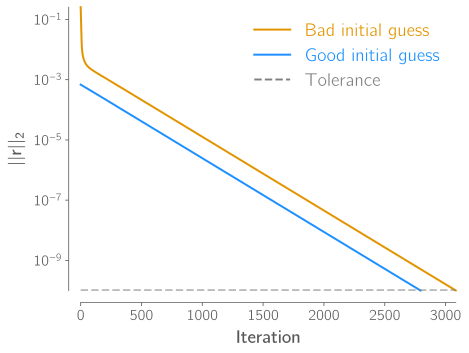

In [74]:
T_init_good = np.linspace(T0, TN, Nx + 1)
T_init_bad = np.copy(T_init_good)
T_init_bad[1:-1] = 0.

x = np.linspace(0, L, Nx + 1)
q_array = q(x, L)

T_sol_bad, res_history_bad, iter_times_bad = iterativeSolve(T_init_bad, q_array, kappa, L / Nx, gaussSeidelIteration, omega=1.4, tol=tol)
T_sol_good, res_history_good, iter_times_good = iterativeSolve(T_init_good, q_array, kappa, L / Nx, gaussSeidelIteration, omega=1.4, tol=tol)

fig, ax = plt.subplots()
ax.set_yscale("log")
ax.set_xlabel("Iteration")
ax.set_ylabel("$||r||_2$")
ax.plot(res_history_bad, clip_on=False, label="Bad initial guess")
ax.plot(res_history_good, clip_on=False, label="Good initial guess")
ax.axhline(tol, color="Gray", linestyle="--", label="Tolerance")
ax.legend(labelcolor="linecolor")
niceplots.adjust_spines(ax)

To demonstrate how different frequencies of error are reduced at different rates, we'll run 10 iterations starting from the true solution plus a high frequency error and then starting from the true solution plus a low frequency error.

Iteration 0: Res norm = 8.45e-06
Iteration 1: Res norm = 8.42e-06
Iteration 2: Res norm = 8.39e-06
Iteration 3: Res norm = 8.36e-06
Iteration 4: Res norm = 8.33e-06
Iteration 5: Res norm = 8.30e-06
Iteration 6: Res norm = 8.27e-06
Iteration 7: Res norm = 8.24e-06
Iteration 8: Res norm = 8.21e-06
Iteration 9: Res norm = 8.19e-06
Iteration 0: Res norm = 2.06e-03
Iteration 1: Res norm = 1.38e-03
Iteration 2: Res norm = 9.15e-04
Iteration 3: Res norm = 6.02e-04
Iteration 4: Res norm = 3.98e-04
Iteration 5: Res norm = 2.67e-04
Iteration 6: Res norm = 1.81e-04
Iteration 7: Res norm = 1.23e-04
Iteration 8: Res norm = 8.23e-05
Iteration 9: Res norm = 5.46e-05


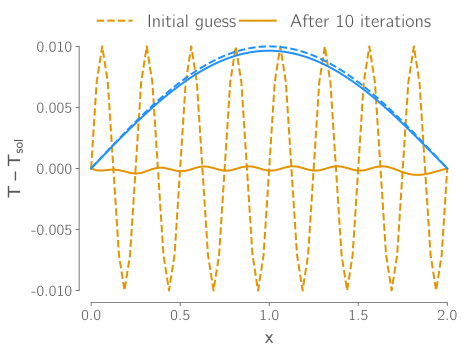

In [75]:
T_init_highfreq = T_sol_good + 0.01*np.sin(16*np.pi*x/L)
T_init_lowfreq = T_sol_good + 0.01*np.sin(1*np.pi*x/L)

T_sol_lowfreq, res_history_lowfreq, iter_times_lowfreq = iterativeSolve(T_init_lowfreq, q_array, kappa, L / Nx, gaussSeidelIteration, omega=1.2, tol=1e-14, maxIter=10)
T_sol_highfreq, res_history_highfreq, iter_times_highfreq = iterativeSolve(T_init_highfreq, q_array, kappa, L / Nx, gaussSeidelIteration, omega=1.2, tol=1e-14, maxIter=10)

fig, ax = plt.subplots()
ax.set_xlabel("x")
ax.set_ylabel(r"$T - T_{sol}$")
ax.plot(x, T_init_highfreq - T_sol_good, "--",  c=niceColors[0], label="Initial guess", clip_on=False)
ax.plot(x, T_init_lowfreq - T_sol_good, "--",  c=niceColors[1], clip_on=False)
ax.plot(x, T_sol_highfreq - T_sol_good, c=niceColors[0], label="After 10 iterations", clip_on=False)
ax.plot(x, T_sol_lowfreq - T_sol_good, c=niceColors[1], clip_on=False)
ax.legend(ncol=2, loc="lower right", bbox_to_anchor=(1.0, 1.0))
niceplots.adjust_spines(ax)

## Implementing a basic 2-level multigrid solver

In this example we are going to implement a very simple 2-level multigrid smoother to use in out iterative solver algorithm.  Note that this is not a great implementation, it is hardcoded to use only 2 levels. In your next homework you will be given the task of implementing a more general multigrid solver that can use any number of levels.

A 2-level multigrid iteration consists of the following steps:
- Running $n_\text{pre}$ iterations of a smoother on the fine grid
- Restricting/averaging the residual to the coarse grid
- Running $n_\text{coarse}$ iterations of a smoother on the coarse grid
- Prolonging/interpolating the coarse grid correction to the fine grid
- Adding the fine grid correction to the solution
- Running $n_\text{post}$ iterations of a smoother on the fine grid

In this implementation, our coarse grid is exactly a factor of 2 coarser that the fine grid, the stencils for the restriction and prolongation operators are therefore pretty simple, as shown below.
In more complex codes, it may not be possible generate such an ideal coarse grid and the restriction and prolongation operators may be more complex averaging/interpolation operators.

![Full weighting restriction](../../images/MultigridRestriction.png)

In [76]:
# Define residual restriction operator from fine grid to coarse grid using full-weighting
def restrict_to_coarse(r_fine):
    return 0.25 * r_fine[0:-2:2] + 0.5 * r_fine[1:-1:2] + 0.25 * r_fine[2::2]


![Prolongation](../../images/MultigridProlongation.png)

In [77]:
# Define prolongation operator from coarse grid to fine grid
def prolongate_to_fine(u_coarse):
    u_fine = np.zeros(2 * (len(u_coarse)-1) + 1)  # Create an empty fine grid
    # Assign values from coarse grid directly for even elements
    u_fine[2:-2:2] = u_coarse[1:-1]
    # Use weights 1/2 and 1/2 for odd elements
    u_fine[1:-1:2] = 0.5 * (u_coarse[:-1] + u_coarse[1:])
    return u_fine